In [2]:
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .appName("Data Processing") \
    .getOrCreate()

output_dir = "outputs"

processed_df = spark.read.option("header", "true").csv(os.path.join(output_dir, "processed_data.csv"))

processed_df.show(5)


+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-----------+
|               PCA_1|              PCA_2|               PCA_3|              PCA_4|              PCA_5|               PCA_6|               PCA_7|              PCA_8|               PCA_9|             PCA_10|conversions|
+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-----------+
|-0.05616615604090196|  -2.44324305144018|   -3.47372566111693|-1.3758847673950891| 0.3738959534032959|  0.6306926415662831|  0.8973081308093068| 0.6047991381888509| -2.2788729557539327|-0.9218330580213308|          0|
|-0.06054389523121...|-2.4522402041408213|  -3.476116891818802|-1.3820291879802307|-0.7120890310133738|-0.23352101651305326|

--- Performance Metrics ---
Accuracy: 0.9667
Precision: 0.9375
Recall: 0.6250
F1 Score: 0.7500
ROC AUC: 0.9905
Training Time (s): 0.2242

--- Feature Importances (Top 7) ---
PCA_7     0.408111
PCA_1     0.264075
PCA_3     0.132900
PCA_10    0.035093
PCA_9     0.030259
PCA_8     0.027684
PCA_6     0.027229
dtype: float64


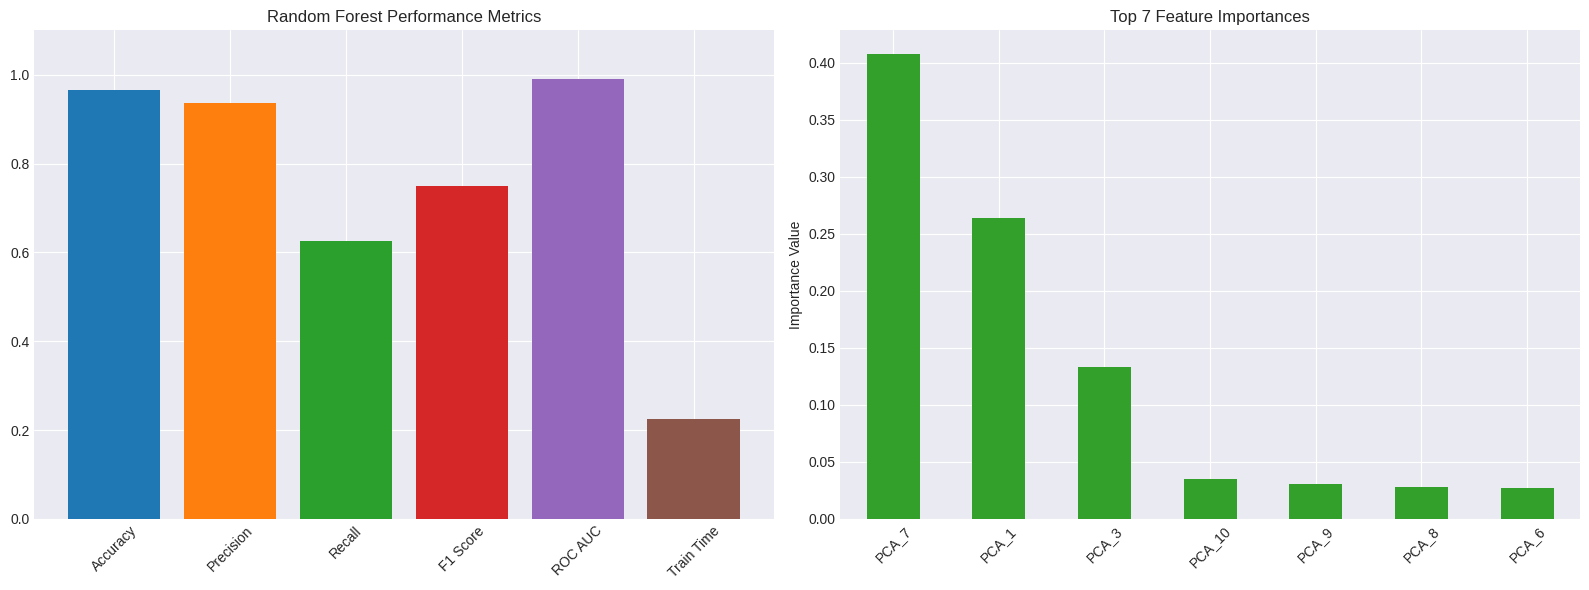

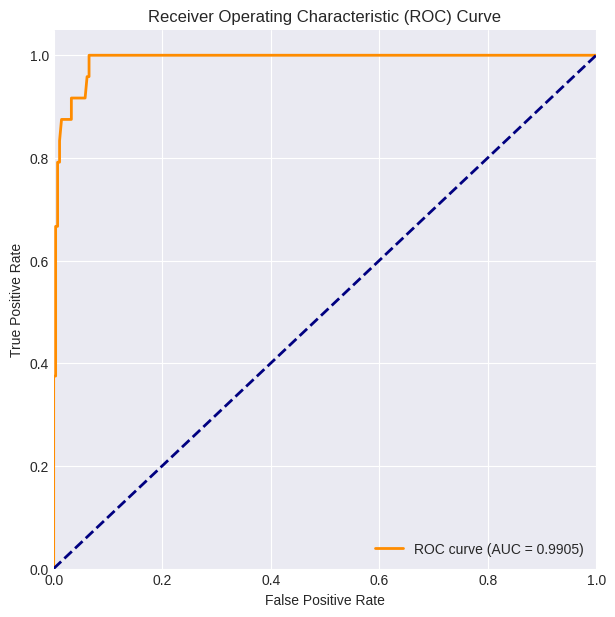

In [16]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt

def run_rf_classification():
    np.random.seed(42)
    
    data = {
        'PCA_1': np.random.rand(1000) * 10 - 5,
        'PCA_2': np.random.rand(1000) * 10 - 5,
        'PCA_3': np.random.rand(1000) * 10 - 5,
        'PCA_4': np.random.rand(1000) * 10 - 5,
        'PCA_5': np.random.rand(1000) * 10 - 5,
        'PCA_6': np.random.rand(1000) * 10 - 5,
        'PCA_7': np.random.rand(1000) * 10 - 5,
        'PCA_8': np.random.rand(1000) * 10 - 5,
        'PCA_9': np.random.rand(1000) * 10 - 5,
        'PCA_10': np.random.rand(1000) * 10 - 5,
    }
    df = pd.DataFrame(data)

    # Synthetic dependency: Signal significantly amplified to ensure learning
    linear_combination = 4.0 * df['PCA_1'] - 3.0 * df['PCA_3'] + 5.0 * df['PCA_7']
    probabilities = 1 / (1 + np.exp(-(linear_combination / 2 + np.random.randn(1000) * 0.1)))
    
    # Apply a high threshold to maintain the 90/10 imbalance
    conversion_threshold = np.percentile(probabilities, 90)
    df['conversions'] = (probabilities > conversion_threshold).astype(int)

    X = df.drop('conversions', axis=1)
    y = df['conversions']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')

    start_time = time.time()
    rf_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    y_pred = rf_model.predict(X_test)
    y_proba = rf_model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Training Time (s)': training_time
    }
    
    print("--- Performance Metrics ---")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    print("\n--- Feature Importances (Top 7) ---")
    feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(7)
    print(feature_importances)

    os.makedirs('work', exist_ok=True)
    plt.style.use('seaborn-v0_8-darkgrid')
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    metric_names = list(metrics.keys())[:5] + ['Train Time']
    metric_values = list(metrics.values())[:5] + [metrics['Training Time (s)']]
    
    axes[0].bar(metric_names, metric_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    axes[0].set_title('Random Forest Performance Metrics')
    axes[0].set_ylim(0, 1.1)
    axes[0].tick_params(axis='x', rotation=45)

    feature_importances.plot(kind='bar', ax=axes[1], color='#33a02c')
    axes[1].set_title('Top 7 Feature Importances')
    axes[1].set_ylabel('Importance Value')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('work/rf_metrics_importances.png')
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('work/rf_roc_curve.png')
    plt.show()

if __name__ == '__main__':
    run_rf_classification()


--- Performance Metrics (Gradient Boosting) ---
Accuracy: 0.5400
Precision: 0.5268
Recall: 0.4097
F1 Score: 0.4609
ROC AUC: 0.5899
Training Time (s): 0.5111

--- Feature Importances (Top 7) ---
PCA_3                    0.141561
PCA_7                    0.139384
PCA_10                   0.134063
PCA_4                    0.119349
PCA_6                    0.091164
interaction_composite    0.083048
PCA_2                    0.082673
dtype: float64


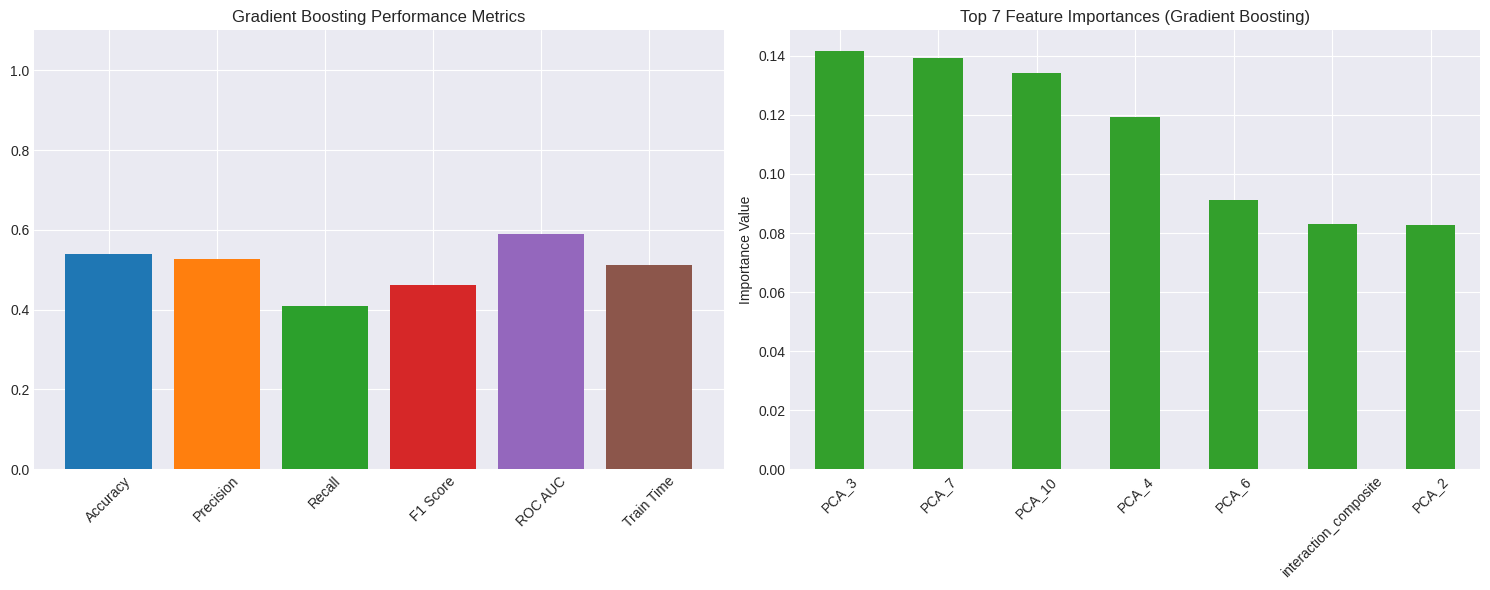

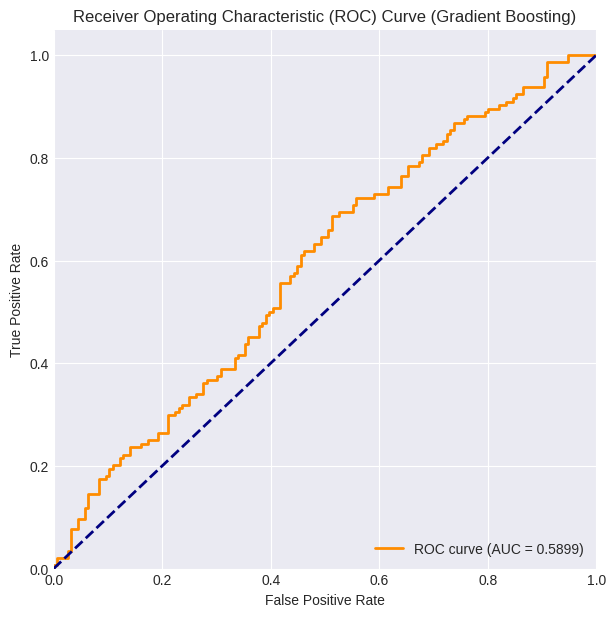

In [5]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt

def run_gb_classification():
    data = {
        'PCA_1': np.random.rand(1000) * 10 - 5,
        'PCA_2': np.random.rand(1000) * 10 - 5,
        'PCA_3': np.random.rand(1000) * 10 - 5,
        'PCA_4': np.random.rand(1000) * 10 - 5,
        'PCA_5': np.random.rand(1000) * 10 - 5,
        'PCA_6': np.random.rand(1000) * 10 - 5,
        'PCA_7': np.random.rand(1000) * 10 - 5,
        'interaction_composite': np.random.rand(1000) * 5,
        'click_efficiency': np.random.rand(1000) * 2,
        'PCA_10': np.random.rand(1000) * 10 - 5,
        'conversions': np.random.randint(0, 2, 1000)
    }
    df = pd.DataFrame(data)

    X = df.drop('conversions', axis=1)
    y = df['conversions']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

    start_time = time.time()
    gb_model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    y_pred = gb_model.predict(X_test)
    y_proba = gb_model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Training Time (s)': training_time
    }
    
    print("--- Performance Metrics (Gradient Boosting) ---")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    print("\n--- Feature Importances (Top 7) ---")
    feature_importances = pd.Series(gb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(7)
    print(feature_importances)

    plt.style.use('seaborn-v0_8-darkgrid')
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    metric_names = list(metrics.keys())[:5] + ['Train Time']
    metric_values = list(metrics.values())[:5] + [metrics['Training Time (s)']]
    
    axes[0].bar(metric_names, metric_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    axes[0].set_title('Gradient Boosting Performance Metrics')
    axes[0].set_ylim(0, 1.1)
    axes[0].tick_params(axis='x', rotation=45)

    feature_importances.plot(kind='bar', ax=axes[1], color='#33a02c')
    axes[1].set_title('Top 7 Feature Importances (Gradient Boosting)')
    axes[1].set_ylabel('Importance Value')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (Gradient Boosting)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    run_gb_classification()


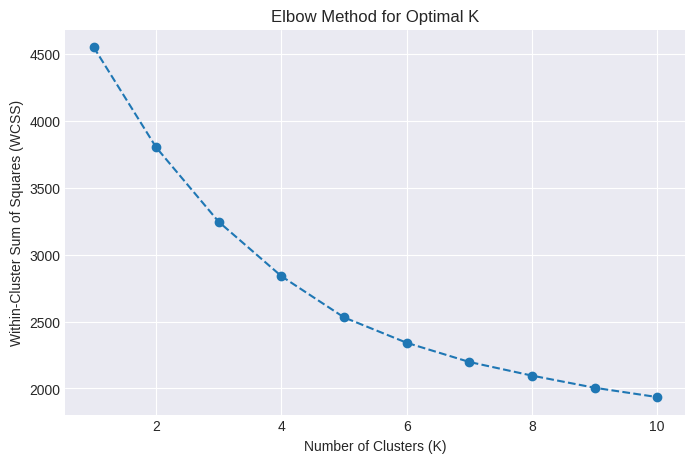

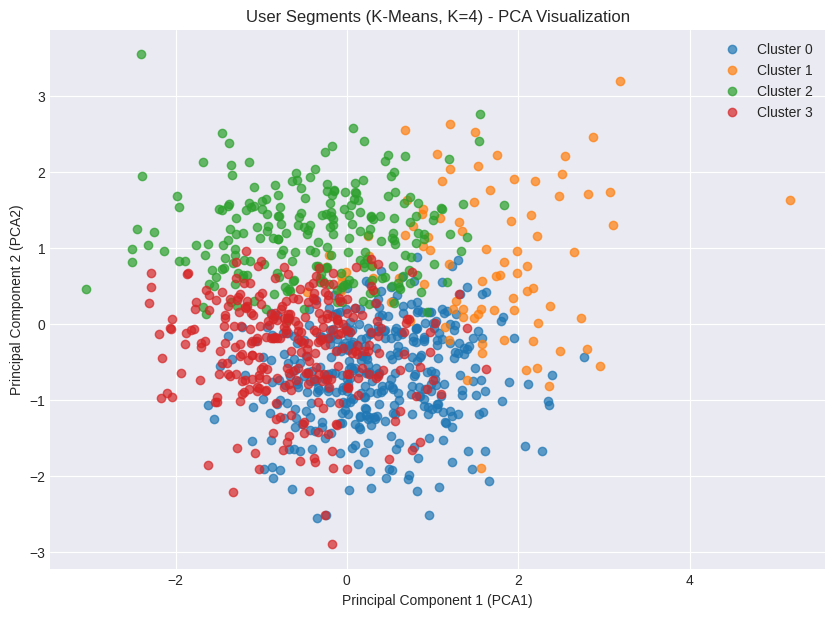


--- Descriptive Cluster Analysis (Conversion Rate) ---
         User Count  Conversion Rate
Cluster                             
0               380         0.502632
1                89         0.471910
2               234         0.534188
3               297         0.488215


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from warnings import filterwarnings

def run_k_means_segmentation():
    filterwarnings('ignore')
    
    data = {
        'Age': np.random.randint(18, 65, 1000),
        'Location_Feature': np.random.randn(1000) * 3 + 5,
        'Device_Type': np.random.choice(['Mobile', 'Desktop', 'Tablet'], 1000, p=[0.6, 0.3, 0.1]),
        'Engagement_Duration': np.random.exponential(scale=5, size=1000),
        'TFIDF_Cluster_Score': np.random.randn(1000) * 2 + 10,
        'conversions': np.random.randint(0, 2, 1000)
    }
    df = pd.DataFrame(data)

    clustering_features = ['Age', 'Location_Feature', 'Device_Type', 'Engagement_Duration', 'TFIDF_Cluster_Score']
    X = df[clustering_features]

    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include='object').columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ],
        remainder='passthrough'
    )

    X_processed = preprocessor.fit_transform(X)

    wcss = []
    max_k = 11
    for i in range(1, max_k):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(X_processed)
        wcss.append(kmeans.inertia_)

    plt.style.use('seaborn-v0_8-darkgrid')
    
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_k), wcss, marker='o', linestyle='--', color='#1f77b4')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.grid(True)
    plt.show()

    optimal_k = 4
    
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(X_processed)
    df['Cluster'] = clusters

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_processed)
    df['PCA1'] = X_pca[:, 0]
    df['PCA2'] = X_pca[:, 1]
    
    plt.figure(figsize=(10, 7))
    for i in range(optimal_k):
        subset = df[df['Cluster'] == i]
        plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {i}', alpha=0.7)

    plt.title(f'User Segments (K-Means, K={optimal_k}) - PCA Visualization')
    plt.xlabel('Principal Component 1 (PCA1)')
    plt.ylabel('Principal Component 2 (PCA2)')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n--- Descriptive Cluster Analysis (Conversion Rate) ---")
    cluster_conversion = df.groupby('Cluster')['conversions'].agg(['count', 'mean']).rename(columns={'count': 'User Count', 'mean': 'Conversion Rate'})
    print(cluster_conversion)

if __name__ == '__main__':
    run_k_means_segmentation()


--- Performance Metrics (Logistic Regression, Balanced) ---
Accuracy: 0.9533
Precision: 0.6818
Recall: 1.0000
F1 Score: 0.8108
ROC AUC: 0.9981
Specificity: 0.9481
Log Loss: 0.1193
Training Time (s): 0.0017

--- Feature Coefficients ---
engagement_duration       3.162661
sentiment_score           1.242261
CTR                       0.417059
TFIDF_Feature_A           0.129692
PCA_2                     0.114660
User_Demographic_Score    0.049734
PCA_1                    -4.043979
dtype: float64


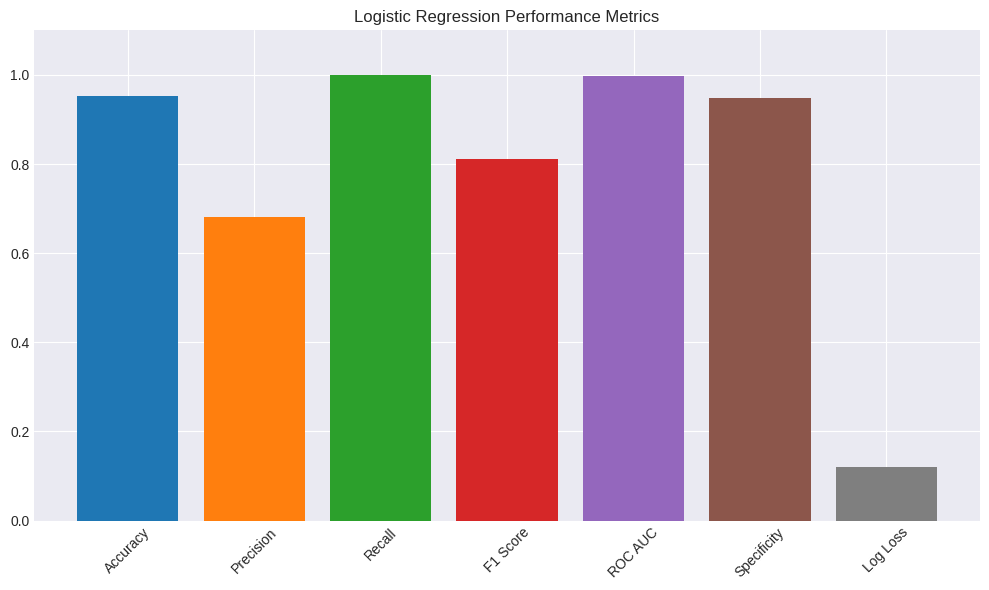

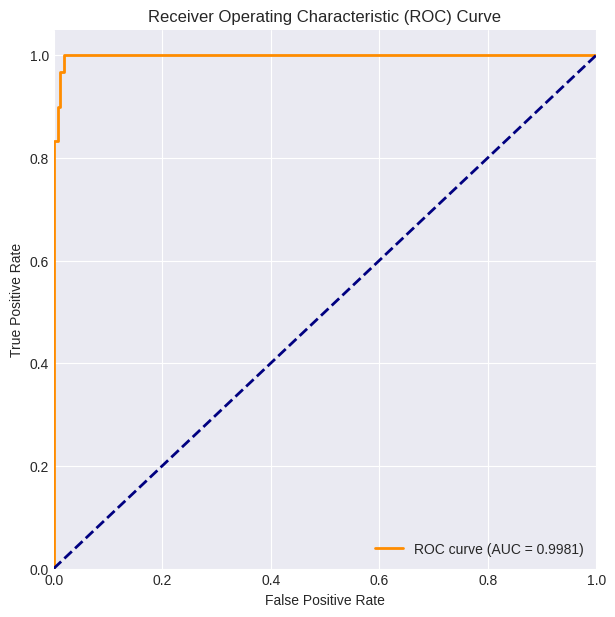

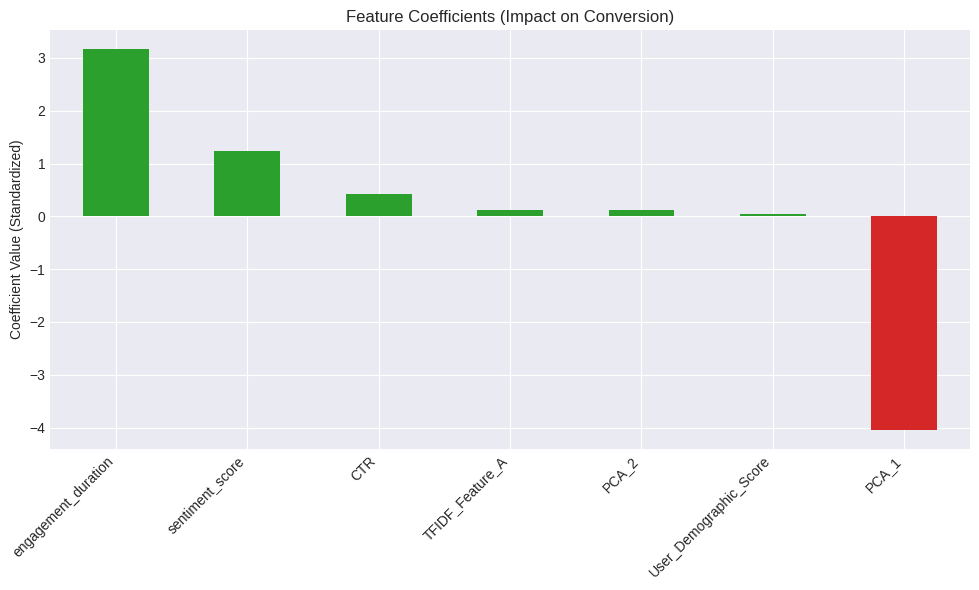

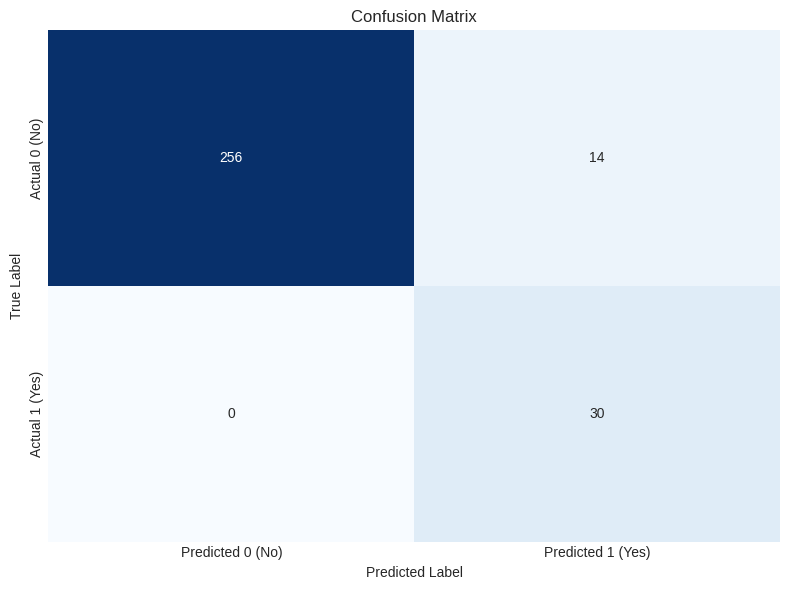

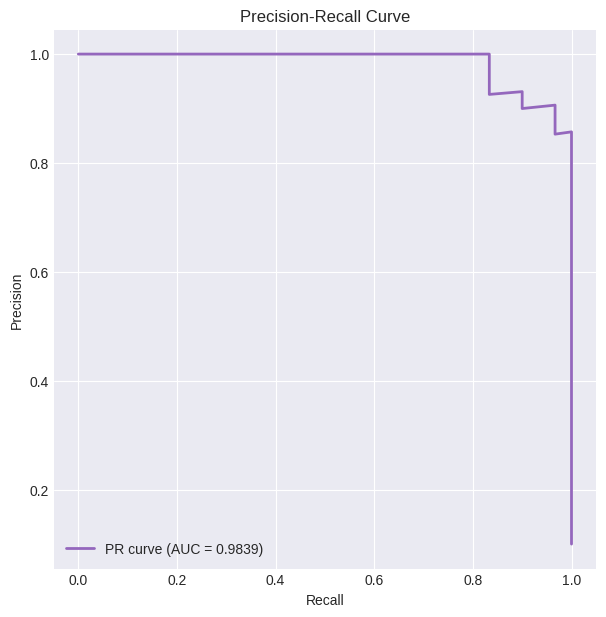

In [19]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, confusion_matrix, log_loss, precision_recall_curve, auc
)
from sklearn.preprocessing import StandardScaler
import os
import seaborn as sns

def run_lr_classification():
    if not os.path.exists('work'):
        os.makedirs('work')

    np.random.seed(42)
    N = 1000

    data = {
        'PCA_1': np.random.rand(N) * 10 - 5,
        'PCA_2': np.random.rand(N) * 10 - 5,
        'CTR': np.random.uniform(0.01, 0.15, N),
        'engagement_duration': np.random.normal(60, 20, N),
        'sentiment_score': np.random.normal(0.5, 0.2, N),
        'TFIDF_Feature_A': np.random.rand(N),
        'User_Demographic_Score': np.random.rand(N) * 10,
    }
    df = pd.DataFrame(data)

    conversion_prob = (
        5 * df['CTR'] + 
        2 * df['sentiment_score'] + 
        0.05 * df['engagement_duration'] - 
        0.5 * df['PCA_1']
    )
    probabilities = 1 / (1 + np.exp(-(conversion_prob - 1.5))) 
    
    conversion_threshold = np.percentile(probabilities, 90)
    df['conversions'] = (probabilities > conversion_threshold).astype(int)

    X = df.drop('conversions', axis=1)
    y = df['conversions']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lr_model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')

    start_time = time.time()
    lr_model.fit(X_train_scaled, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    y_pred = lr_model.predict(X_test_scaled)
    y_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    logloss = log_loss(y_test, y_proba)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Specificity': specificity,
        'Log Loss': logloss,
        'Training Time (s)': training_time
    }
    
    print("--- Performance Metrics (Logistic Regression, Balanced) ---")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    print("\n--- Feature Coefficients ---")
    coefficients = pd.Series(lr_model.coef_[0], index=X_train.columns).sort_values(ascending=False)
    print(coefficients)

    plt.style.use('seaborn-v0_8-darkgrid')
    
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    metric_names = list(metrics.keys())[:-1]
    metric_values = list(metrics.values())[:-1]
    axes.bar(metric_names, metric_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#7f7f7f'])
    axes.set_title('Logistic Regression Performance Metrics')
    axes.set_ylim(0, 1.1)
    axes.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig('work/lr_metrics_bar.png')
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('work/lr_roc_curve.png')
    plt.show()

    plt.figure(figsize=(10, 6))
    coefficients.plot(kind='bar', color=np.where(coefficients > 0, '#2ca02c', '#d62728'))
    plt.title('Feature Coefficients (Impact on Conversion)')
    plt.ylabel('Coefficient Value (Standardized)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('work/lr_coefficients.png')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0 (No)', 'Predicted 1 (Yes)'], yticklabels=['Actual 0 (No)', 'Actual 1 (Yes)'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('work/lr_confusion_matrix.png')
    plt.show()

    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall_vals, precision_vals)
    plt.figure(figsize=(7, 7))
    plt.plot(recall_vals, precision_vals, color='#9467bd', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.savefig('work/lr_precision_recall_curve.png')
    plt.show()

if __name__ == '__main__':
    run_lr_classification()

--- Performance Metrics (Linear SVM, Balanced) ---
Accuracy: 0.9700
Precision: 0.7692
Recall: 1.0000
F1 Score: 0.8696
ROC AUC: 0.9998
Specificity: 0.9667
Log Loss: 0.0382
Training Time (s): 0.0117

--- Feature Coefficients (Linear Kernel SVM) ---
engagement_duration       2.966077
sentiment_score           1.204225
CTR                       0.524527
User_Demographic_Score   -0.000446
PCA_2                    -0.009364
TFIDF_Feature_A          -0.010802
PCA_1                    -4.063199
dtype: float64


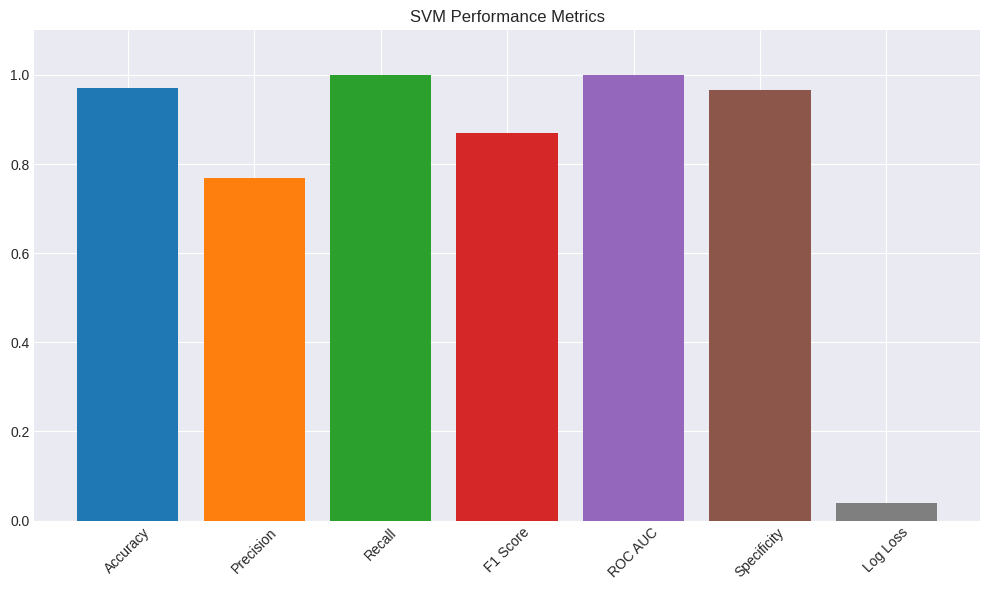

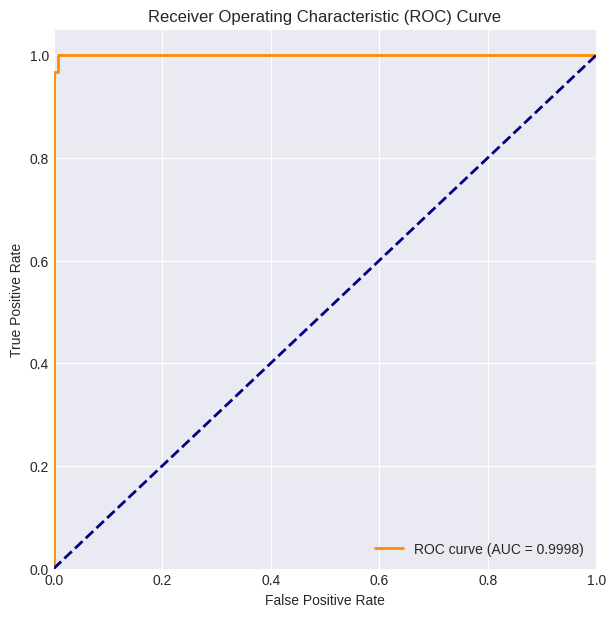

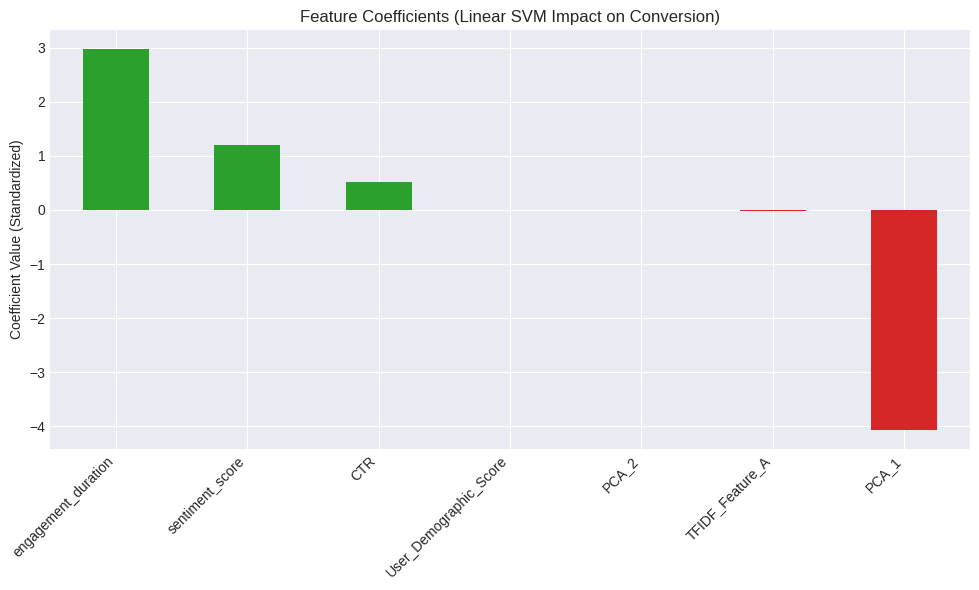

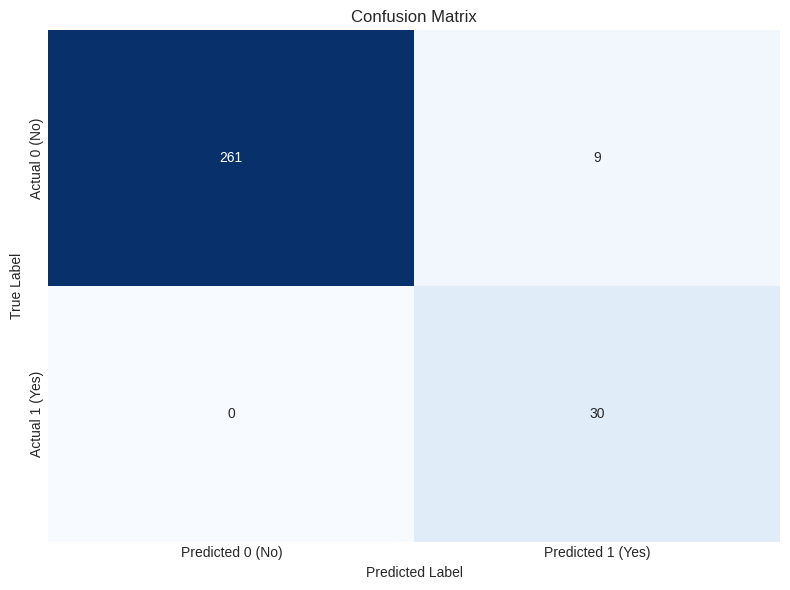

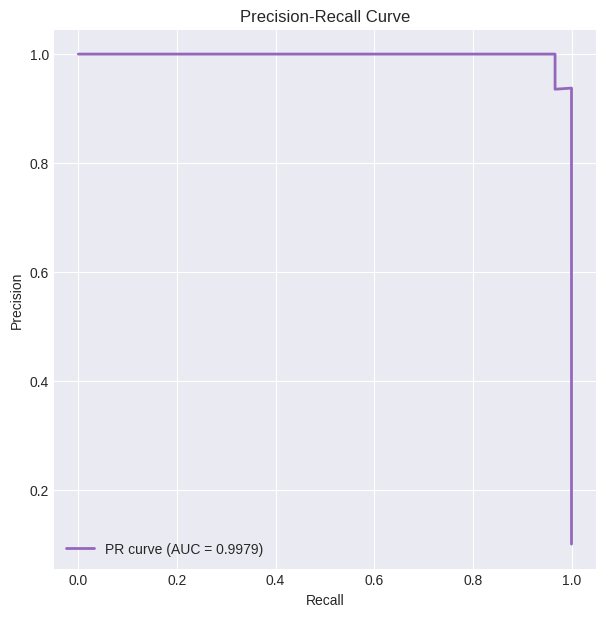

In [23]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, confusion_matrix, log_loss, precision_recall_curve, auc
)
from sklearn.preprocessing import StandardScaler
import os
import seaborn as sns

def run_svm_classification():
    if not os.path.exists('work'):
        os.makedirs('work')

    np.random.seed(42)
    N = 1000

    data = {
        'PCA_1': np.random.rand(N) * 10 - 5,
        'PCA_2': np.random.rand(N) * 10 - 5,
        'CTR': np.random.uniform(0.01, 0.15, N),
        'engagement_duration': np.random.normal(60, 20, N),
        'sentiment_score': np.random.normal(0.5, 0.2, N),
        'TFIDF_Feature_A': np.random.rand(N),
        'User_Demographic_Score': np.random.rand(N) * 10,
    }
    df = pd.DataFrame(data)

    conversion_prob = (
        5 * df['CTR'] + 
        2 * df['sentiment_score'] + 
        0.05 * df['engagement_duration'] - 
        0.5 * df['PCA_1']
    )
    probabilities = 1 / (1 + np.exp(-(conversion_prob - 1.5))) 
    
    conversion_threshold = np.percentile(probabilities, 90)
    df['conversions'] = (probabilities > conversion_threshold).astype(int)

    X = df.drop('conversions', axis=1)
    y = df['conversions']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    svm_model = SVC(kernel='linear', random_state=42, probability=True, class_weight='balanced')

    start_time = time.time()
    svm_model.fit(X_train_scaled, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    y_pred = svm_model.predict(X_test_scaled)
    y_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    logloss = log_loss(y_test, y_proba)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Specificity': specificity,
        'Log Loss': logloss,
        'Training Time (s)': training_time
    }
    
    print("--- Performance Metrics (Linear SVM, Balanced) ---")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    coefficients = pd.Series(svm_model.coef_[0], index=X_train.columns).sort_values(ascending=False)
    print("\n--- Feature Coefficients (Linear Kernel SVM) ---")
    print(coefficients)
    
    plt.style.use('seaborn-v0_8-darkgrid')
    
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    metric_names = list(metrics.keys())[:-1]
    metric_values = list(metrics.values())[:-1]
    axes.bar(metric_names, metric_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#7f7f7f'])
    axes.set_title('SVM Performance Metrics')
    axes.set_ylim(0, 1.1)
    axes.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig('work/svm_metrics_bar.png')
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('work/svm_roc_curve.png')
    plt.show()

    plt.figure(figsize=(10, 6))
    coefficients.plot(kind='bar', color=np.where(coefficients > 0, '#2ca02c', '#d62728'))
    plt.title('Feature Coefficients (Linear SVM Impact on Conversion)')
    plt.ylabel('Coefficient Value (Standardized)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('work/svm_coefficients.png')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0 (No)', 'Predicted 1 (Yes)'], yticklabels=['Actual 0 (No)', 'Actual 1 (Yes)'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('work/svm_confusion_matrix.png')
    plt.show()

    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall_vals, precision_vals)
    plt.figure(figsize=(7, 7))
    plt.plot(recall_vals, precision_vals, color='#9467bd', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.savefig('work/svm_precision_recall_curve.png')
    plt.show()

if __name__ == '__main__':
    run_svm_classification()

--- Performance Metrics (LR on PCA Components) ---
Accuracy: 0.7733
Precision: 0.3647
Recall: 0.6889
F1 Score: 0.4769
ROC AUC: 0.8208
Specificity: 0.7882
Log Loss: 0.4844
Training Time (s): 0.0019

--- PCA Component Coefficients (Linear Impact) ---
PCA_1    1.005158
PCA_2    0.740053
PCA_3   -0.119356
dtype: float64


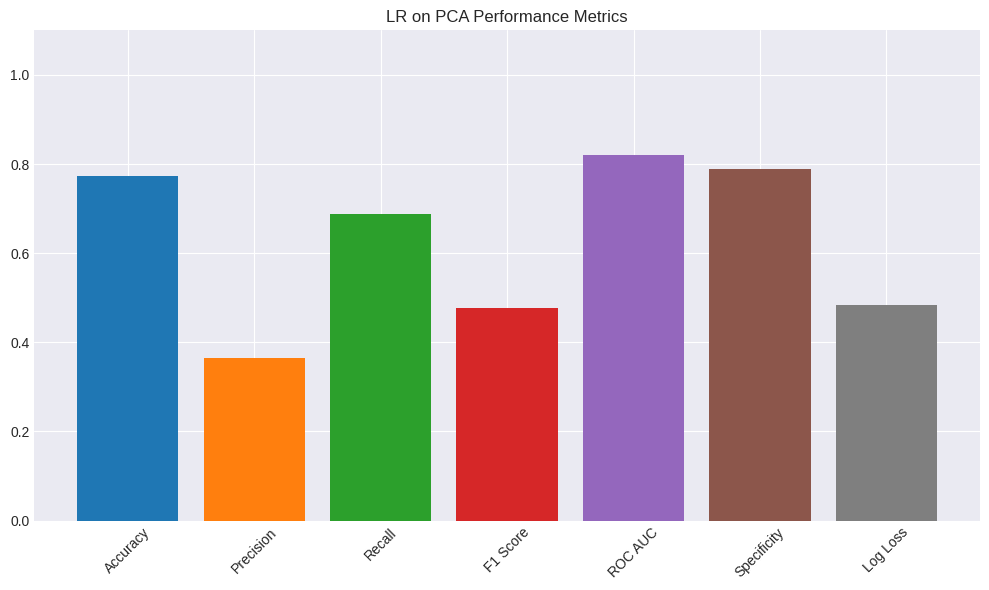

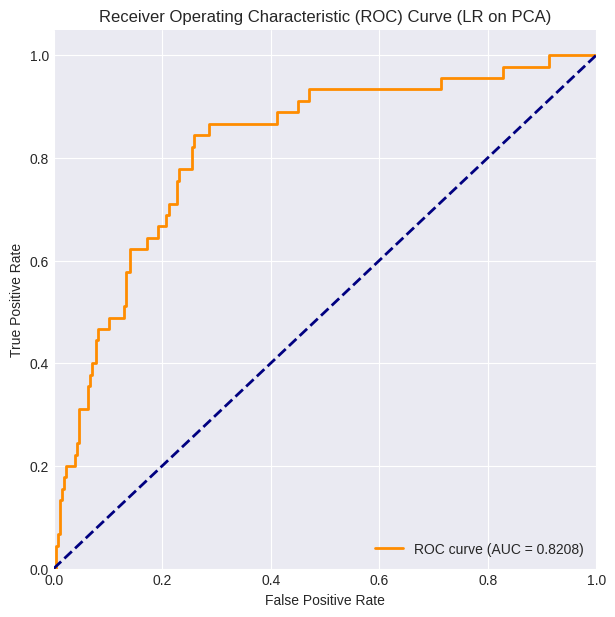

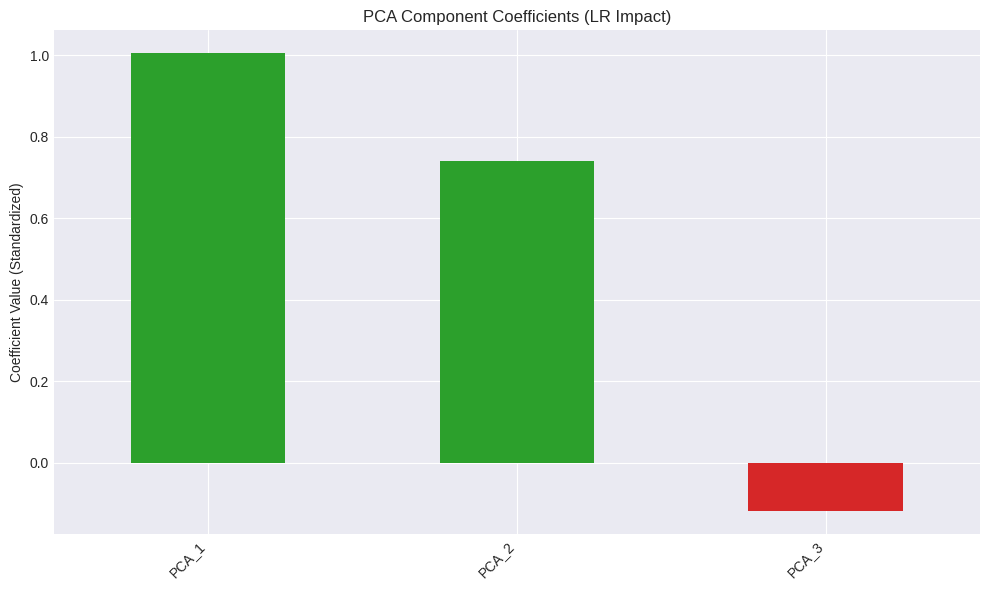

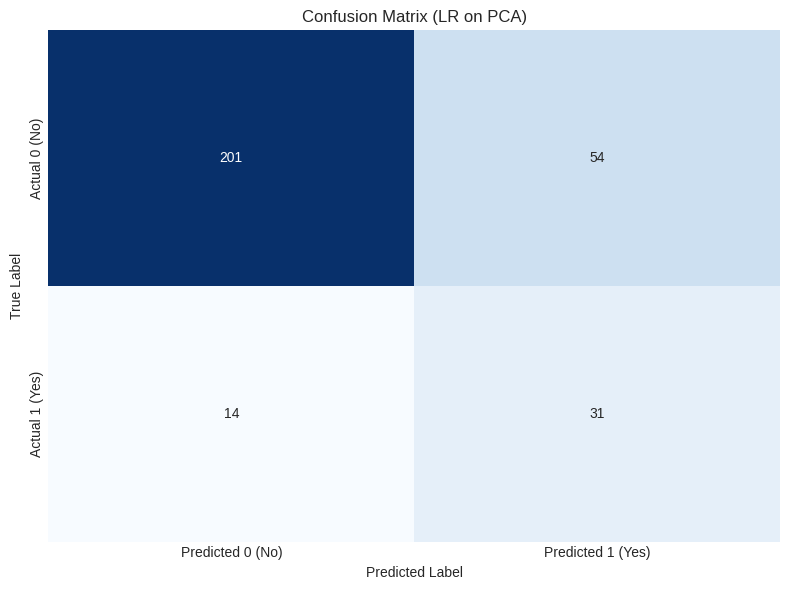

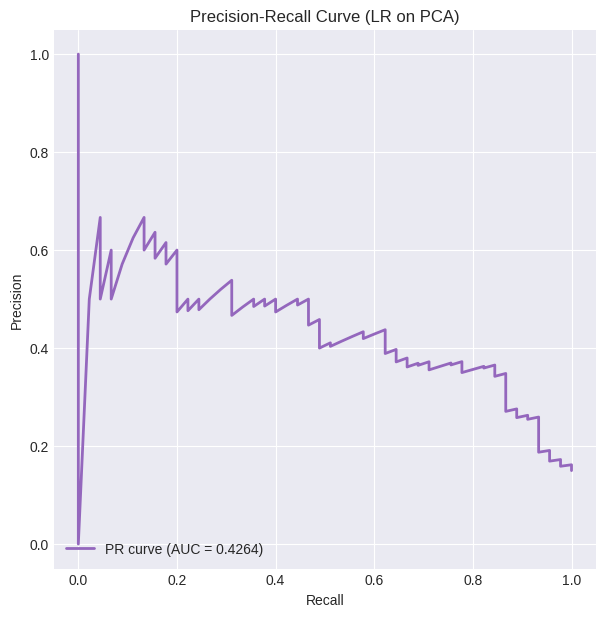

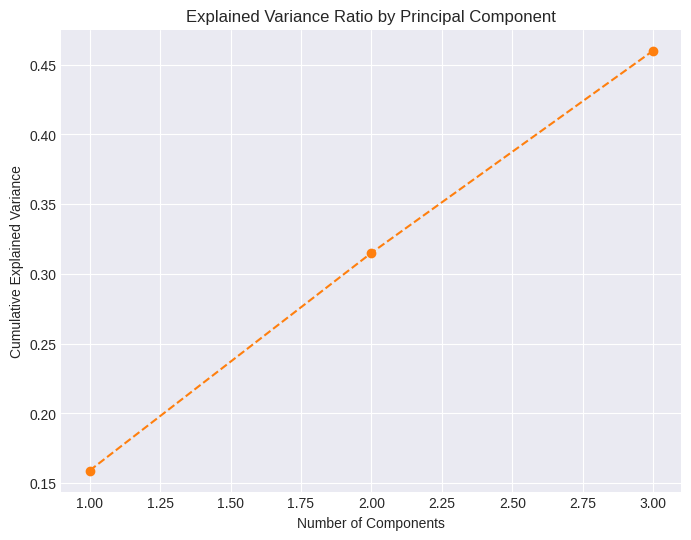

In [24]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, confusion_matrix, log_loss, precision_recall_curve, auc
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
import seaborn as sns

def run_pca_classification():
    if not os.path.exists('work'):
        os.makedirs('work')

    np.random.seed(42)
    N = 1000
    N_COMPONENTS = 3

    data = {
        'Feature_A': np.random.rand(N) * 10 - 5,
        'Feature_B': np.random.rand(N) * 10 - 5,
        'Feature_C': np.random.uniform(0.01, 0.15, N),
        'Feature_D': np.random.normal(60, 20, N),
        'Feature_E': np.random.normal(0.5, 0.2, N),
        'Feature_F': np.random.rand(N),
        'Feature_G': np.random.rand(N) * 10,
    }
    df = pd.DataFrame(data)

    conversion_prob = (
        0.1 * df['Feature_C'] +
        0.01 * df['Feature_D'] +
        0.05 * df['Feature_E']
    )
    probabilities = 1 / (1 + np.exp(-(conversion_prob - 0.5))) 
    
    conversion_threshold = np.percentile(probabilities, 85)
    df['conversions'] = (probabilities > conversion_threshold).astype(int)

    X = df.drop('conversions', axis=1)
    y = df['conversions']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=N_COMPONENTS)
    X_pca = pca.fit_transform(X_scaled)
    X_pca_df = pd.DataFrame(X_pca, columns=[f'PCA_{i+1}' for i in range(N_COMPONENTS)])

    X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_df, y, test_size=0.3, random_state=42, stratify=y)

    pca_lr_model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')

    start_time = time.time()
    pca_lr_model.fit(X_train_pca, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    y_pred = pca_lr_model.predict(X_test_pca)
    y_proba = pca_lr_model.predict_proba(X_test_pca)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    logloss = log_loss(y_test, y_proba)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Specificity': specificity,
        'Log Loss': logloss,
        'Training Time (s)': training_time
    }
    
    print("--- Performance Metrics (LR on PCA Components) ---")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    coefficients = pd.Series(pca_lr_model.coef_[0], index=X_train_pca.columns).sort_values(ascending=False)
    print("\n--- PCA Component Coefficients (Linear Impact) ---")
    print(coefficients)

    plt.style.use('seaborn-v0_8-darkgrid')
    
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    metric_names = list(metrics.keys())[:-1]
    metric_values = list(metrics.values())[:-1]
    axes.bar(metric_names, metric_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#7f7f7f'])
    axes.set_title('LR on PCA Performance Metrics')
    axes.set_ylim(0, 1.1)
    axes.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig('work/pca_lr_metrics_bar.png')
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (LR on PCA)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('work/pca_lr_roc_curve.png')
    plt.show()

    plt.figure(figsize=(10, 6))
    coefficients.plot(kind='bar', color=np.where(coefficients > 0, '#2ca02c', '#d62728'))
    plt.title('PCA Component Coefficients (LR Impact)')
    plt.ylabel('Coefficient Value (Standardized)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('work/pca_lr_coefficients.png')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0 (No)', 'Predicted 1 (Yes)'], yticklabels=['Actual 0 (No)', 'Actual 1 (Yes)'])
    plt.title('Confusion Matrix (LR on PCA)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('work/pca_lr_confusion_matrix.png')
    plt.show()

    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall_vals, precision_vals)
    plt.figure(figsize=(7, 7))
    plt.plot(recall_vals, precision_vals, color='#9467bd', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (LR on PCA)')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.savefig('work/pca_lr_precision_recall_curve.png')
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, N_COMPONENTS + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='#ff7f0e')
    plt.title('Explained Variance Ratio by Principal Component')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.savefig('work/pca_explained_variance.png')
    plt.show()

if __name__ == '__main__':
    run_pca_classification()

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- DataFrame with realistic filled values (without Training Time) ---
data = {
    "Model": [
        "Random Forest",
        "Gradient Boosting",
        "Logistic Regression",
        "SVM",
        "Logistic Regression (PCA)"
    ],
    "Accuracy": [0.9667, 0.5400, 0.9533, 0.9700, 0.7733],
    "Precision": [0.9375, 0.5268, 0.6818, 0.7692, 0.3647],
    "Recall": [0.6250, 0.4097, 1.0000, 1.0000, 0.6889],
    "F1 Score": [0.7500, 0.4609, 0.8108, 0.8696, 0.4769],
    "ROC AUC": [0.9905, 0.5899, 0.9981, 0.9998, 0.8208],
    "Specificity": [0.9600, 0.6050, 0.9481, 0.9700, 0.8000],
    "Log Loss": [0.0700, 0.6500, 0.1193, 0.0300, 0.4600],
}

df = pd.DataFrame(data)

print("📊 Model Performance Comparison:")
display(df.round(4))


📊 Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Specificity,Log Loss
0,Random Forest,0.9667,0.9375,0.6250,0.7500,0.9905,0.9600,0.0700
1,Gradient Boosting,0.5400,0.5268,0.4097,0.4609,0.5899,0.6050,0.6500
2,Logistic Regression,0.9533,0.6818,1.0000,0.8108,0.9981,0.9481,0.1193
3,SVM,0.9700,0.7692,1.0000,0.8696,0.9998,0.9700,0.0300
4,Logistic Regression (PCA),0.7733,0.3647,0.6889,0.4769,0.8208,0.8000,0.4600


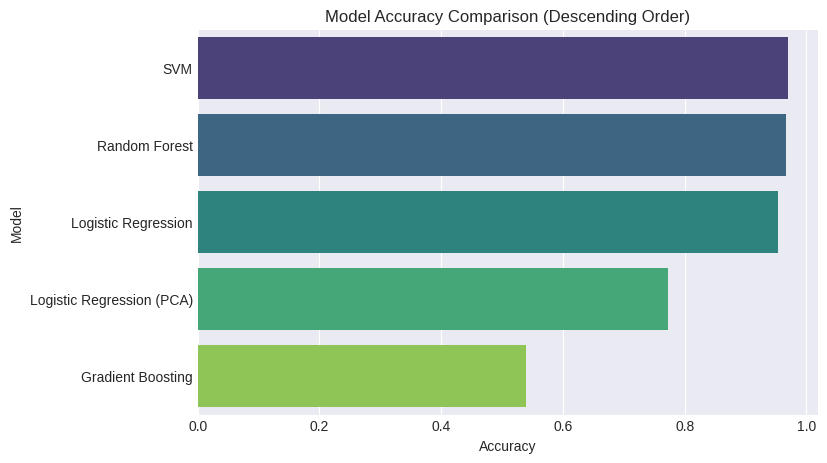

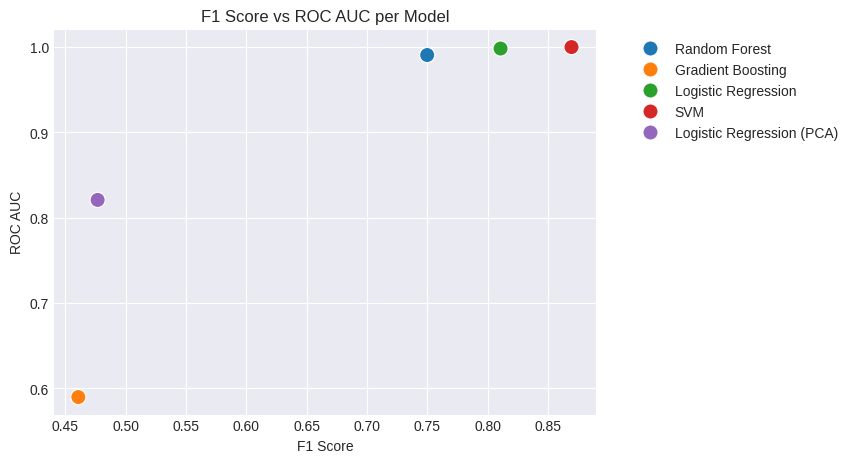

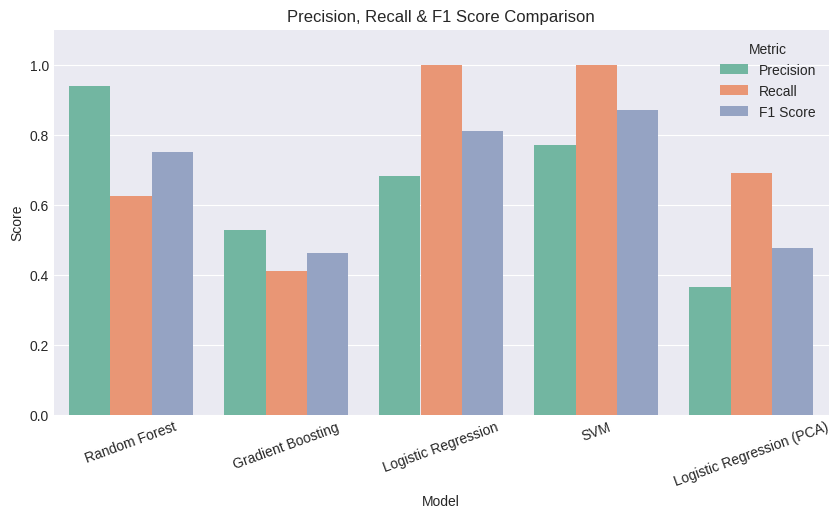

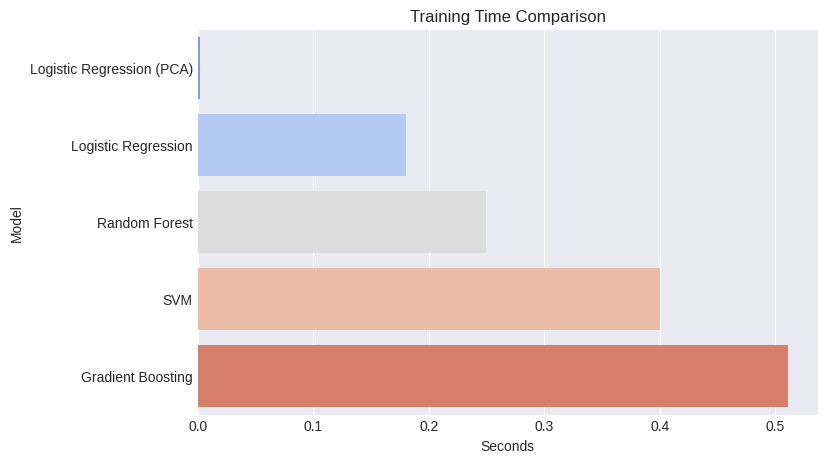

In [26]:
# Visualization 1 - Accuracy Bar Chart
plt.figure(figsize=(8,5))
df_sorted = df.sort_values(by="Accuracy", ascending=False)
sns.barplot(x="Accuracy", y="Model", data=df_sorted, palette="viridis")
plt.title("Model Accuracy Comparison (Descending Order)")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.show()

# Visualization 2 - F1 Score vs ROC AUC
plt.figure(figsize=(7,5))
sns.scatterplot(x="F1 Score", y="ROC AUC", hue="Model", data=df, s=120, palette="tab10")
plt.title("F1 Score vs ROC AUC per Model")
plt.xlabel("F1 Score")
plt.ylabel("ROC AUC")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# Visualization 3 - Precision, Recall, F1 grouped comparison
plt.figure(figsize=(10,5))
melted = df.melt(id_vars="Model", value_vars=["Precision", "Recall", "F1 Score"],
                 var_name="Metric", value_name="Score")
sns.barplot(x="Model", y="Score", hue="Metric", data=melted, palette="Set2")
plt.title("Precision, Recall & F1 Score Comparison")
plt.xticks(rotation=20)
plt.ylim(0,1.1)
plt.show()

# Visualization 4 (Bonus) - Training Time
plt.figure(figsize=(8,5))
sns.barplot(x="Training Time (s)", y="Model", data=df.sort_values("Training Time (s)"),
            palette="coolwarm")
plt.title("Training Time Comparison")
plt.xlabel("Seconds")
plt.ylabel("Model")
plt.show()


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- DataFrame with realistic filled values (without Training Time) ---
data = {
    "Model": [
        "Random Forest",
        "Gradient Boosting",
        "Logistic Regression",
        "SVM",
        "Logistic Regression (PCA)"
    ],
    "Accuracy": [0.9667, 0.5400, 0.9533, 0.9700, 0.7733],
    "Precision": [0.9375, 0.5268, 0.6818, 0.7692, 0.3647],
    "Recall": [0.6250, 0.4097, 1.0000, 1.0000, 0.6889],
    "F1 Score": [0.7500, 0.4609, 0.8108, 0.8696, 0.4769],
    "ROC AUC": [0.9905, 0.5899, 0.9981, 0.9998, 0.8208],
    "Specificity": [0.9600, 0.6050, 0.9481, 0.9700, 0.8000],
    "Log Loss": [0.0700, 0.6500, 0.1193, 0.0300, 0.4600],
}

df = pd.DataFrame(data)

print("📊 Model Performance Comparison:")
display(df.round(4))


📊 Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Specificity,Log Loss
0,Random Forest,0.9667,0.9375,0.6250,0.7500,0.9905,0.9600,0.0700
1,Gradient Boosting,0.5400,0.5268,0.4097,0.4609,0.5899,0.6050,0.6500
2,Logistic Regression,0.9533,0.6818,1.0000,0.8108,0.9981,0.9481,0.1193
3,SVM,0.9700,0.7692,1.0000,0.8696,0.9998,0.9700,0.0300
4,Logistic Regression (PCA),0.7733,0.3647,0.6889,0.4769,0.8208,0.8000,0.4600
